# Energy-constrained mesoscale eddy parameterisations in NEMO5

In [1]:
import cmocean
import glob
import gsw
import os
import numpy  as np
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcl

## Define and load experiments

In [2]:
# Absolute paths to the configuration
nemo_path = '/home/torresr/Programmes/nemo_5.0.1/'
config    = 'GYRE_PISCES'

# Experiments
exp_def   = {'Spin-up': {'name': 'EXPSPIN', 'color': 'tab:blue'},
             'CONST'  : {'name': 'EXPCTRL', 'color': 'tab:blue'},
             'GROWTH' : {'name': 'EXPEIV',  'color': 'tab:orange'},
             'GEOM'   : {'name': 'EXPGEOM', 'color': 'tab:green'},
            }

# Output options
save_figs = True

In [3]:
# Load experiment
exp_datas = dict()

for exp in exp_def:
    d     = exp_datas.setdefault(exp, dict())
    epath = os.path.join(nemo_path, 'cfgs', config, exp_def[exp]['name'])

    if not os.path.isdir(epath):
        print("Warning - path '{}' not found ({} ignored).".format(epath, exp))
        continue

    # Read mesh and mask
    if os.path.isfile(epath + '/mesh_mask.nc'):
        ds = xr.load_dataset(epath + '/mesh_mask.nc')
        d.setdefault('mesh', ds)
    
    # Read all output files and store as xarray.Datasets
    output_files = [f for f in glob.glob(epath + '/GYRE_*.nc') if 'restart' not in f]

    for f in output_files:
        freq = os.path.basename(output_files[0]).split('_')[1]
        grid = ''.join(os.path.basename(f).split('_')[-2:])[:-3]

        ds   = xr.load_dataset(f)
        d.setdefault((freq, grid), ds)

        # -- recompute dx, dy, and dz (not necessary since e1*, e2* and e3* can be read in mesh_mask.nc)
        if 'deptht_bounds' in ds:
            # dz
            ds['dz'] = ds['deptht_bounds'][:, -1] - ds['deptht_bounds'][:, 0]
        elif 'depthu_bounds' in ds:
            ds['dz'] = ds['depthu_bounds'][:, -1] - ds['depthu_bounds'][:, 0]
        elif 'depthv_bounds' in ds:
            ds['dz'] = ds['depthv_bounds'][:, -1] - ds['depthv_bounds'][:, 0]        
        elif 'depthw_bounds' in ds:
            ds['dz'] = ds['depthw_bounds'][:, -1] - ds['depthw_bounds'][:, 0]

        # dx, dy
        shpe             = list(ds['nav_lon'].shape)
        shpe[1]          += 1
        lon_bnds         = np.zeros(tuple(shpe))
        lon_bnds[:, 0]   = ds['nav_lon'][:, 0]  - (ds['nav_lon'][:, 1] - ds['nav_lon'][:, 0])/2.
        lon_bnds[:, -1]  = ds['nav_lon'][:,-1]  + (ds['nav_lon'][:,-1] - ds['nav_lon'][:,-2])/2.
        lon_bnds[:,1:-1] = (ds['nav_lon'][:,1:] + ds['nav_lon'][:,:-1]) / 2.
        # --
        shpe             = list(ds['nav_lat'].shape)
        shpe[0]          += 1
        lat_bnds         = np.zeros(tuple(shpe))
        lat_bnds[0, :]   = ds['nav_lat'][0, :]  - (ds['nav_lat'][1, :] - ds['nav_lat'][0, :])/2.
        lat_bnds[-1, :]  = ds['nav_lat'][-1,:]  + (ds['nav_lat'][-1,:] - ds['nav_lat'][-2,:])/2.
        lat_bnds[1:-1,:] = (ds['nav_lat'][1:,:] + ds['nav_lat'][:-1,:]) / 2.
        # --
        earth_r  = 6378137.
        ds['dx'] = earth_r * np.cos(ds['nav_lat']*np.pi/180.) * (2*np.pi) * (lon_bnds[:, 1:] - lon_bnds[:, :-1])/360.
        ds['dy'] = earth_r * xr.full_like(ds['nav_lat'], 1.)  * (2*np.pi) * (lat_bnds[1:, :] - lat_bnds[:-1, :])/360.

### Check the evolution of the global-averaged temperature

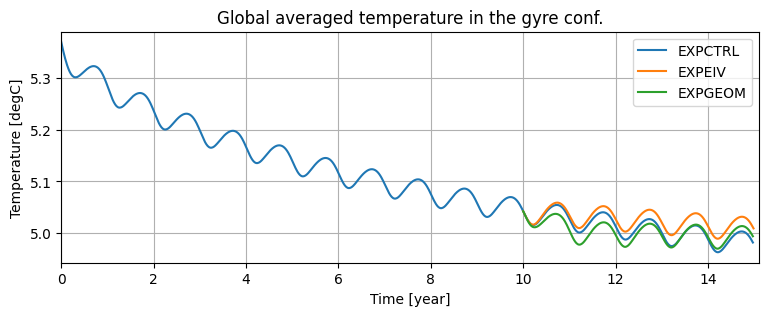

In [4]:
# Select file and variable
table = ('5d', 'gridT')
var   = 'votemper'

# Create figure with matplotlib
fig, ax = plt.subplots(figsize=(9, 3))

it0 = 0
for exp in exp_datas:
    ds  = exp_datas[exp][table]
    
    # compute volume
    vol = ds['dx'] * ds['dy'] * ds['dz']
    dat = (vol * ds[var]).sum(('x', 'y', 'deptht')) / vol.sum(('x', 'y', 'deptht'))
    # get time
    t   = exp_datas[exp][table]['time_counter']

    # plot on axis
    col = exp_def[exp]['color']
    lab = exp_def[exp]['name']
    
    if exp == 'Spin-up':
        lab = None
        
    ax.plot(np.arange(it0, it0+len(t))/72, dat, c=col, label=lab)

    if exp == 'Spin-up':
        it0 = len(t)

ax.set_title('Global averaged temperature in the gyre conf.')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Temperature [degC]')

ax.set_xlim((0, 15.1))

ax.grid()
ax.legend()

if save_figs:
    fig.savefig("./imgs/temperature_ts.png", dpi=200)

## Results

In [5]:
# Select the time period for averaging results 
av_period = ('0014-01-01', '0016-01-01')

### Compare $\kappa_{gm}$ formulations

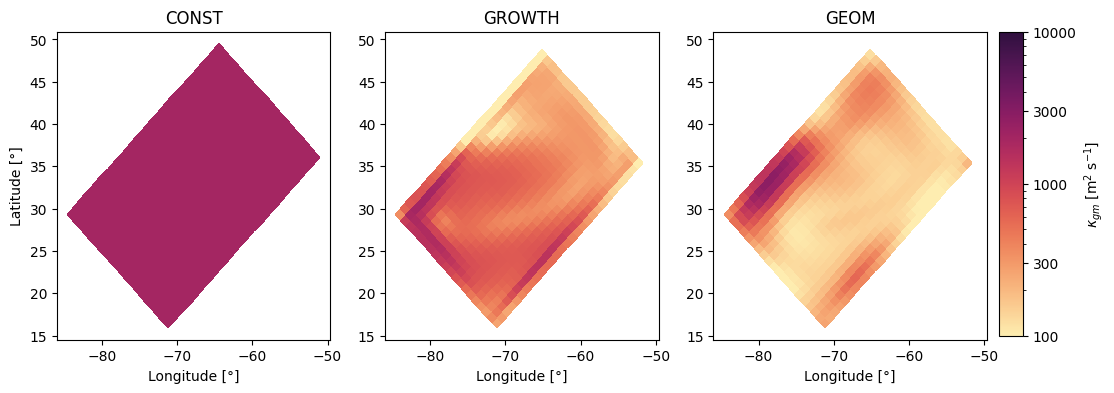

In [6]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsU     = exp_datas[exp][('5d', 'gridU')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    if exp == 'CONST':
        # need to recompute the CONST case since NEMO has not stored it
        Ue  = 0.02
        Le  = 200e3
        Kgm = xr.full_like(dsU['aeiu_2d'], 0.5*Le*Ue) * tmask
    else:
        Kgm = dsU['aeiu_2d'] * tmask

    Kgm = Kgm.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(Kgm['nav_lon'], Kgm['nav_lat'], Kgm, cmap=cmocean.cm.matter, norm=mcl.LogNorm(1e2, 1e4))

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Longitude [°]')

    if i == 0:
        ax.set_ylabel('Latitude [°]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, ticks=[100, 300, 1000, 3000, 10000], orientation='vertical', cax=cb_ax)

cb.ax.set_yticklabels(['100', '300', '1000', '3000', '10000'])
cb.set_label(r"$\kappa_{gm}$ [m$^2$ s$^{-1}$]")

if save_figs:
    fig.savefig("./imgs/Kgm_map.png", dpi=200)

### Barotropic streamfunction

In [7]:
def compute_barotropic_sf(ds_u, ds_v, timeav_per=None):
    """
    Compute the barotropic streamfunction after averaging over a specified time period.
    """
    u = (ds_u['vozocrtx']).sel({'time_counter': slice(*timeav_per)}).mean('time_counter')
    v = (ds_v['vomecrty']).sel({'time_counter': slice(*timeav_per)}).mean('time_counter')

    U = (u * ds_u['dz']).sum('depthu')
    V = (v * ds_v['dz']).sum('depthv')

    psi = (-U * ds_u['dy']).cumsum('y')

    return psi

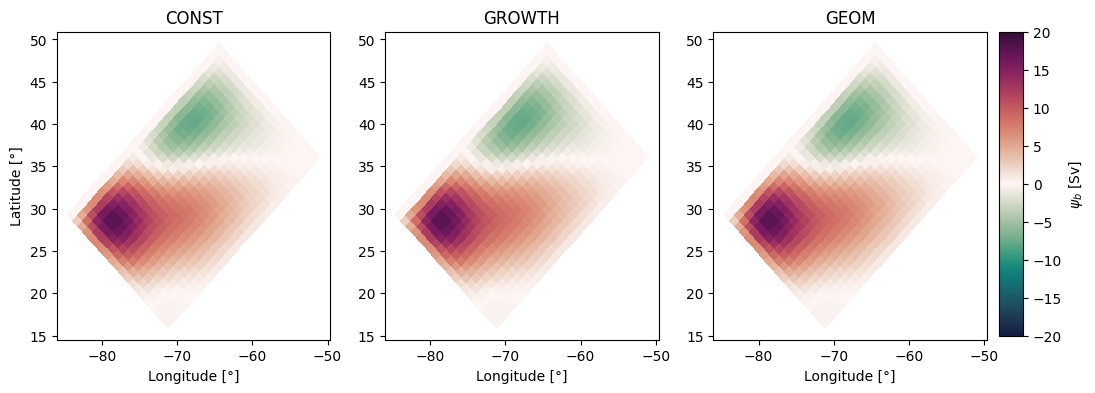

In [8]:
# Options to compute and plot the stream functions
per       = ('0014-01-01', '0016-01-01')

# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # first, compute the stream function and convert coordinates in km
    dsU     = exp_datas[exp][('5d', 'gridU')]
    dsV     = exp_datas[exp][('5d', 'gridV')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)
    
    psi_bt  = compute_barotropic_sf(dsU, dsV, timeav_per=av_period) * tmask
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(psi_bt['nav_lon'], psi_bt['nav_lat'], psi_bt*10**-6, cmap=cmocean.cm.curl, vmin=-20, vmax=+20)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Longitude [°]')

    if i == 0:
        ax.set_ylabel('Latitude [°]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, orientation='vertical', cax=cb_ax)
cb.set_label(r"$\psi_b$ [Sv]")

if save_figs:
    fig.savefig("./imgs/Barotropic_streamfunction_map.png", dpi=200)

### Mixed layer depth

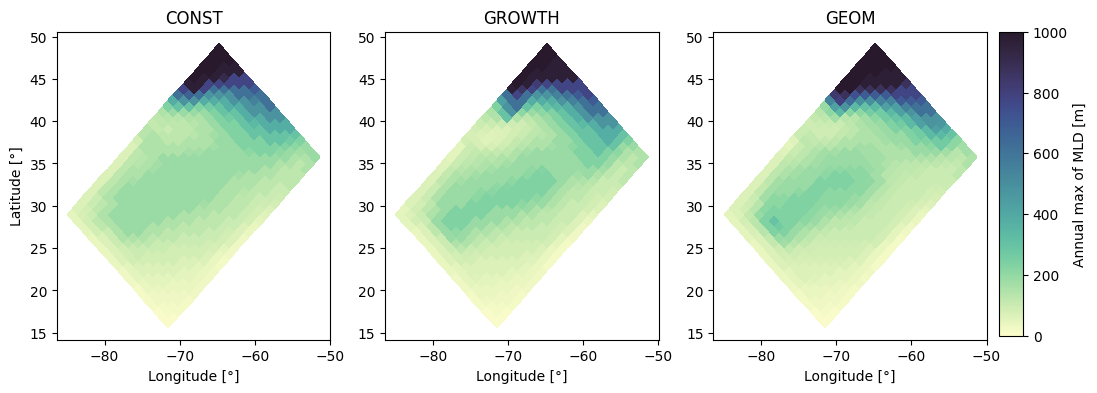

In [9]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # take the annual max and average over the period
    mld     = exp_datas[exp][('5d', 'gridT')]['somixhgt'].sel({'time_counter': slice(*av_period)})
    mld_max = mld.groupby('time_counter.year').max().mean('year')
    mld_max = mld_max * tmask
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(mld_max['nav_lon'], mld_max['nav_lat'], mld_max, cmap=cmocean.cm.deep, vmin=0, vmax=1000)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Longitude [°]')

    if i == 0:
        ax.set_ylabel('Latitude [°]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, orientation='vertical', cax=cb_ax)
cb.set_label(r"Annual max of MLD [m]")

if save_figs:
    fig.savefig("./imgs/MLDmax_map.png", dpi=200)

### Tracer distribution

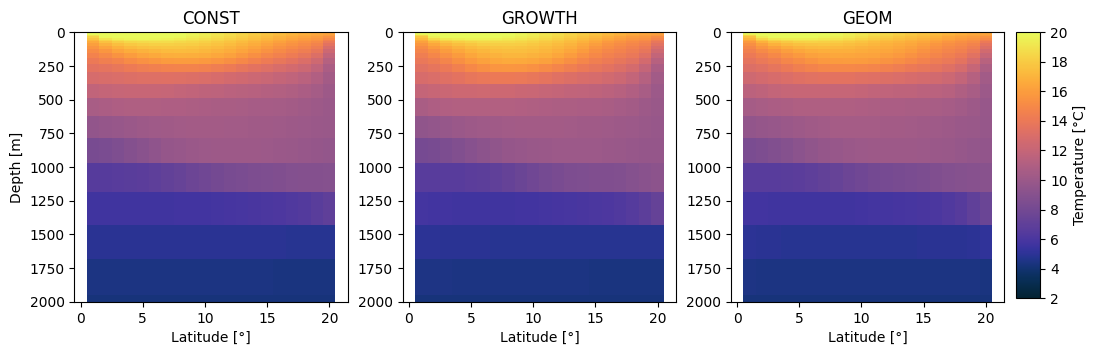

In [10]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'gridT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the temperature
    toce    = (dsT['votemper'] * tmask).mean('x')
    toce    = toce.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(toce['y'], toce['deptht'], toce, cmap=cmocean.cm.thermal, vmin=2, vmax=20)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Latitude [°]')
    ax.set_ylim(0, 2000)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, orientation='vertical', cax=cb_ax)

cb.set_label(r"Temperature [°C]")

if save_figs:
    fig.savefig("./imgs/Temperature_zonal_mean.png", dpi=200)

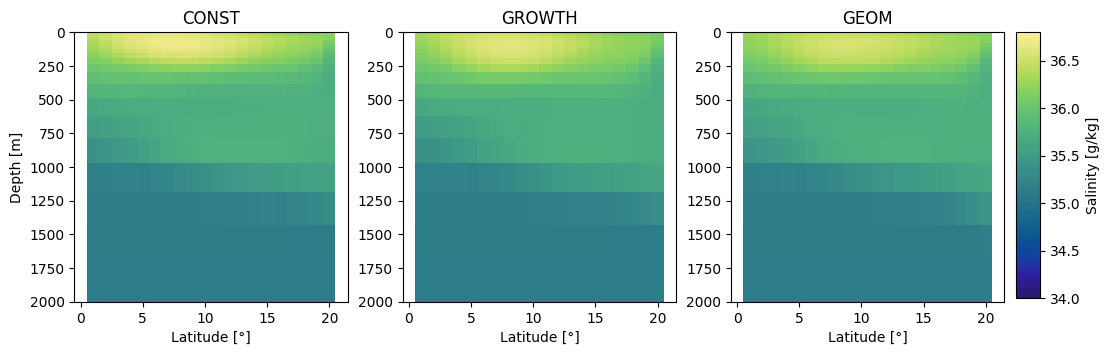

In [11]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'gridT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the salinity
    soce    = (dsT['vosaline'] * tmask).mean('x')
    soce    = soce.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(soce['y'], soce['deptht'], soce, cmap=cmocean.cm.haline, vmin=34, vmax=36.8)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Latitude [°]')
    ax.set_ylim(0, 2000)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, orientation='vertical', cax=cb_ax)

cb.set_label(r"Salinity [g/kg]")

if save_figs:
    fig.savefig("./imgs/Salinity_zonal_mean.png", dpi=200)

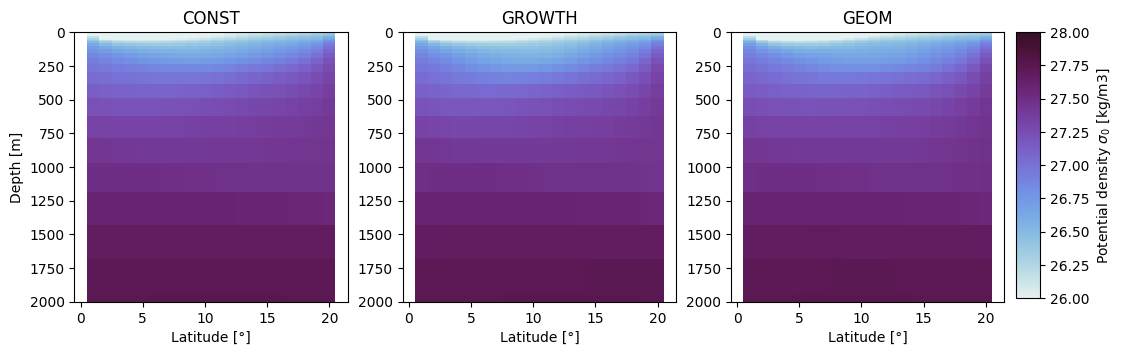

In [12]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'gridT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the density
    toce    = dsT['votemper'] * tmask
    soce    = dsT['vosaline'] * tmask

    bigt    = gsw.CT_from_t(soce, toce, toce['deptht'])
    
    sig0    = gsw.density.sigma0(soce, bigt).mean('x')
    sig0    = sig0.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(sig0['y'], sig0['deptht'], sig0, cmap=cmocean.cm.dense, vmin=26, vmax=28)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Latitude [°]')
    ax.set_ylim(0, 2000)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, orientation='vertical', cax=cb_ax)

cb.set_label(r"Potential density $\sigma_0$ [kg/m3]")

if save_figs:
    fig.savefig("./imgs/Density_zonal_mean.png", dpi=200)

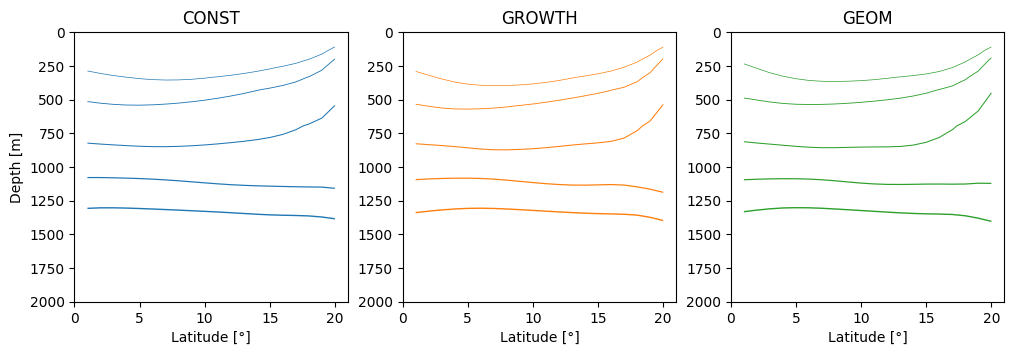

In [17]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'gridT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the density
    toce    = dsT['votemper'] * tmask
    soce    = dsT['vosaline'] * tmask

    bigt    = gsw.CT_from_t(soce, toce, toce['deptht'])
    
    sig0    = gsw.density.sigma0(soce, bigt).mean('x')
    sig0    = sig0.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]

    col = exp_def[exp]['color']
    lab = exp_def[exp]['name']
    
    _ = ax.contour(sig0['y'], sig0['deptht'], sig0, [27., 27.2, 27.4, 27.5, 27.6], linewidths=np.linspace(0.5, 1, 5), colors=col)

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Latitude [°]')
    ax.set_ylim(0, 2000)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

if save_figs:
    fig.savefig("./imgs/Isopycnals.png", dpi=200)

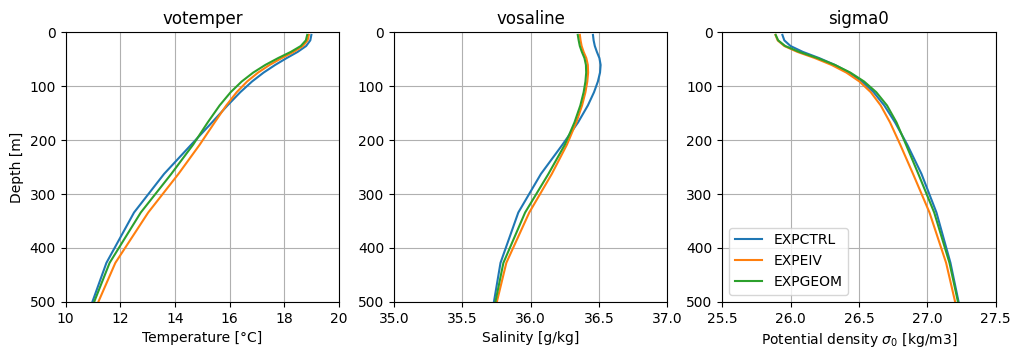

In [18]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

def_var = {'votemper': r'Temperature [°C]', 
           'vosaline': r'Salinity [g/kg]',
           'sigma0': r'Potential density $\sigma_0$ [kg/m3]',
          }

def_lim = {'votemper': (10, 20), 
           'vosaline': (35, 37),
           'sigma0': (25.5, 27.5),
          }

for i, var in enumerate(['votemper', 'vosaline', 'sigma0']):
    ax    = axes[i]
    
    for _, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
        
        # get datas on grid, and select tmask in order to remove unused borders
        dsT     = exp_datas[exp][('5d', 'gridT')]
        tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)
    
        # zonal average of the variable
        if var == 'sigma0':
            toce   = dsT['votemper'] * tmask
            soce   = dsT['vosaline'] * tmask

            bigt   = gsw.CT_from_t(soce, toce, toce['deptht'])
            dat    = gsw.density.sigma0(soce, bigt).mean(('x', 'y'))
            dat     = dat.sel({'time_counter': slice(*av_period)}).mean('time_counter')

        else:
            dat     = (dsT[var] * tmask).mean(('x', 'y'))
            dat     = dat.sel({'time_counter': slice(*av_period)}).mean('time_counter')
            
        # then, plot on the axis
        col = exp_def[exp]['color']
        lab = exp_def[exp]['name']
        _   = ax.plot(dat, dat['deptht'], c=col, label=lab)

    # axis parameters
    ax.set_title(var)
    ax.set_xlabel(def_var.get(var, ''))
    ax.set_xlim(def_lim.get(var, None))
    ax.set_ylim(0, 500)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

    ax.grid()
ax.legend()

if save_figs:
    fig.savefig("./imgs/Hydrographic_profiles.png", dpi=200)

### Nitrate concentration

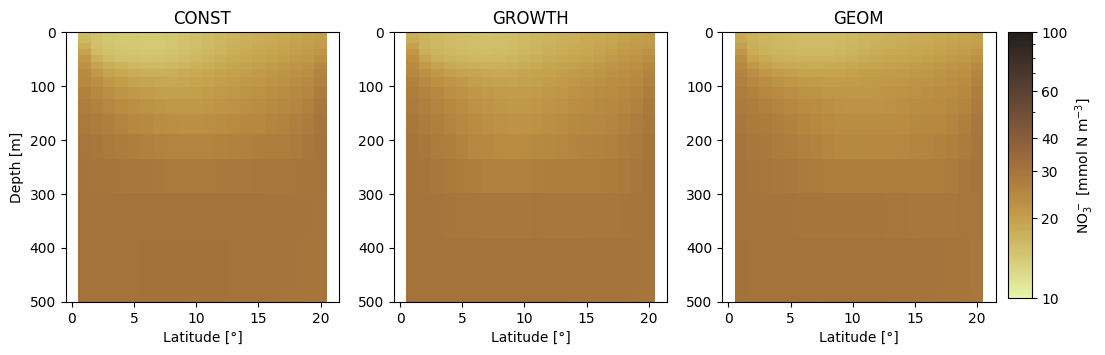

In [19]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'ptrcT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the concentration
    no3     = (dsT['NO3'] * tmask).mean('x')
    no3     = no3.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i]
    qmesh = ax.pcolormesh(no3['y'], no3['deptht'], no3, cmap=cmocean.cm.turbid, norm=mcl.LogNorm(1e1, 1e2))

    # axis parameters
    ax.set_title(exp)
    ax.set_xlabel('Latitude [°]')
    ax.set_ylim(0, 500)
    ax.invert_yaxis()

    if i == 0:
        ax.set_ylabel('Depth [m]')

cb_ax = fig.add_axes([0.91, 0.12, 0.02, 0.76])
cb    = fig.colorbar(qmesh, ticks=[10, 20, 30, 40, 60, 100], orientation='vertical', cax=cb_ax)

cb.ax.set_yticklabels(['10', '20', '30', '40', '60', '100'])
cb.set_label(r"NO$_3^-$ [mmol N m$^{-3}$]")

if save_figs:
    fig.savefig("./imgs/NO3_zonal_mean.png", dpi=200)

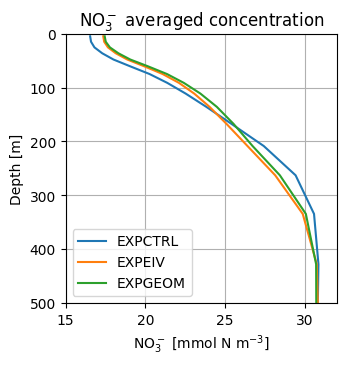

In [20]:
# Create figure with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 3.5))

for i, exp in enumerate(['CONST', 'GROWTH', 'GEOM']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas[exp][('5d', 'ptrcT')]
    tmask   = xr.where(exp_datas[exp]['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    # zonal average of the concentration
    no3     = (dsT['NO3'] * tmask).mean(('x', 'y'))
    no3     = no3.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    col = exp_def[exp]['color']
    lab = exp_def[exp]['name']
    _   = ax.plot(no3, no3['deptht'], c=col, label=lab)

# axis parameters
ax.set_title(r"NO$_3^-$ averaged concentration")

ax.set_xlim(15, 32)
ax.set_xticks([15, 20, 25, 30])
ax.set_xlabel(r"NO$_3^-$ [mmol N m$^{-3}$]")

ax.set_ylim(0, 500)
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')

ax.legend()
ax.grid()

if save_figs:
    fig.savefig("./imgs/NO3_profile.png", dpi=200)

### Eddy energy equation

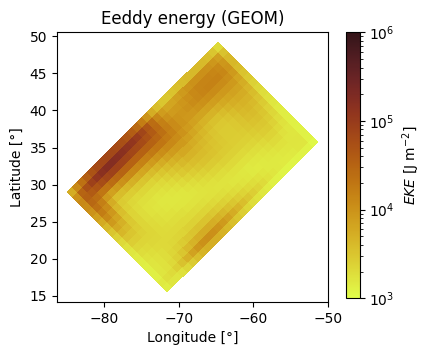

In [21]:
# Create figure with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 3.5))

rho0    = 1026.

# get datas on grid, and select tmask in order to remove unused borders
dsT     = exp_datas['GEOM'][('5d', 'gridT')]
tmask   = xr.where(exp_datas['GEOM']['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

eke     = rho0 * dsT['eke'] * tmask
eke     = eke.sel({'time_counter': slice(*av_period)}).mean('time_counter')

# then, plot on the axis
qmesh = ax.pcolormesh(eke['nav_lon'], eke['nav_lat'], eke, cmap=cmocean.cm.solar_r, 
                      norm=mcl.LogNorm(vmin=1e3, vmax=1e6))

# axis parameters
ax.set_title('Eeddy energy (GEOM)')

ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]')

cb_ax = fig.add_axes([0.95, 0.12, 0.04, 0.76])
cb    = fig.colorbar(qmesh, ticks=[1e3, 1e4, 1e5, 1e6], orientation='vertical', cax=cb_ax)

cb.set_label(r"$EKE$ [J m$^{-2}$]")

if save_figs:
    fig.savefig("./imgs/EXPGEOM_Eddy-Energy.png", dpi=200)

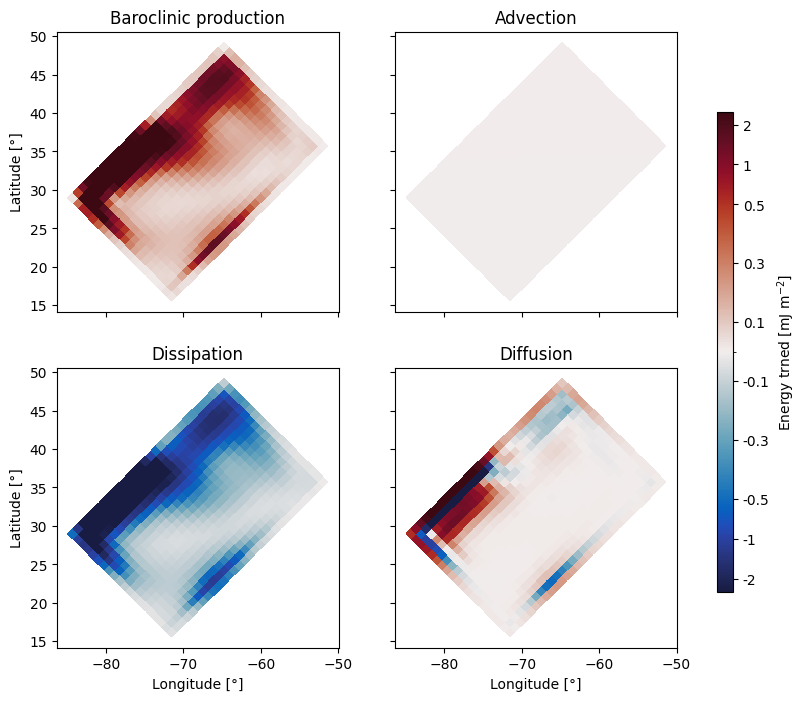

In [22]:
# Create figure with matplotlib
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

rho0    = 1026.
def_var = {'trd_eke_peS': 'Baroclinic production', 
           'trd_eke_dis': 'Dissipation',
           'trd_eke_adv_ubt': 'Advection',
           'trd_eke_lap': 'Diffusion',
          }

for i, var in enumerate(['trd_eke_peS', 'trd_eke_dis', 'trd_eke_adv_ubt', 'trd_eke_lap']):
    
    # get datas on grid, and select tmask in order to remove unused borders
    dsT     = exp_datas['GEOM'][('5d', 'gridT')]
    tmask   = xr.where(exp_datas['GEOM']['mesh']['tmaskutil'].isel({'time_counter': 0})==0, np.nan, 1.)

    trd     = rho0 * dsT[var] * tmask
    trd     = trd.sel({'time_counter': slice(*av_period)}).mean('time_counter')
    
    # then, plot on the axis
    ax    = axes[i%2, i//2]
    qmesh = ax.pcolormesh(trd['nav_lon'], trd['nav_lat'], 1000*trd, cmap=cmocean.cm.balance, 
                          norm=mcl.SymLogNorm(linthresh=0.5, linscale=1, vmin=-2.5, vmax=2.5, base=10))

    # axis parameters
    ax.set_title(def_var.get(var, ''))

    if i%2 == 1:
        ax.set_xlabel('Longitude [°]')
    else:
        ax.set_xticklabels([])

    if i <= 1:
        ax.set_ylabel('Latitude [°]')
    else:
        ax.set_yticklabels([])
        
cb_ax = fig.add_axes([0.95, 0.18, 0.02, 0.6])
cb    = fig.colorbar(qmesh, ticks=[-2, -1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1, 2], orientation='vertical', cax=cb_ax)

cb.ax.set_yticklabels(['-2', '-1', '-0.5', '-0.3', '-0.1', '0.1', '0.3', '0.5', '1', '2'])
cb.set_label(r"Energy trned [mJ m$^{-2}$]")

if save_figs:
    fig.savefig("./imgs/EXPGEOM_Eddy-energy-trd.png", dpi=200)